https://www.analyticsvidhya.com/blog/2021/04/time-series-analysis-forecast-covid-19-vaccination-rate/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

In [12]:
POPULATION = 8804190

In [13]:
def find_criticals(df, arr, default, date_name):
    filter = abs(arr - np.mean(arr)) > (2*np.std(arr))
    critical_indices = np.where(filter)[0]+default
    critical_dates = np.array(df[date_name].to_list())[critical_indices]

    return critical_dates


def calculate_critical_dates(df, period, variable_name, date_name):
    diff_list = df[variable_name].diff(periods=period).to_list()

    default = 0
    for i,num in enumerate(diff_list):
        if not np.isnan(num):
            default = i
            break
    diff_list = diff_list[default:]

    arr = np.array(diff_list).astype(np.float64)

    critical_dates = find_criticals(df, arr, default, date_name)

    return critical_dates

In [14]:
first_load = True

if first_load:
    df_doses_by_day = pd.read_csv("covid-vaccine-data-main\doses\doses-by-day.csv")
    df_doses_by_day["DATE"] = pd.to_datetime(df_doses_by_day["DATE"])
else:
    df_doses_by_day = pd.read_csv("./df_dose_by_day.csv")
    df_doses_by_day["DATE"] = pd.to_datetime(df_doses_by_day["DATE"])

In [15]:
df_doses_by_day.columns

Index(['DATE', 'ADMIN_DOSE1_DAILY', 'ADMIN_DOSE1_CUMULATIVE',
       'ADMIN_DOSE2_DAILY', 'ADMIN_DOSE2_CUMULATIVE', 'ADMIN_SINGLE_DAILY',
       'ADMIN_SINGLE_CUMULATIVE', 'ADMIN_ALLDOSES_DAILY',
       'ADMIN_ALLDOSES_7DAYAVG', 'ADMIN_ALLDOSES_CUMULATIVE', 'INCOMPLETE'],
      dtype='object')

In [16]:
df_doses_by_day.dtypes

DATE                         datetime64[ns]
ADMIN_DOSE1_DAILY                     int64
ADMIN_DOSE1_CUMULATIVE                int64
ADMIN_DOSE2_DAILY                     int64
ADMIN_DOSE2_CUMULATIVE                int64
ADMIN_SINGLE_DAILY                    int64
ADMIN_SINGLE_CUMULATIVE               int64
ADMIN_ALLDOSES_DAILY                  int64
ADMIN_ALLDOSES_7DAYAVG              float64
ADMIN_ALLDOSES_CUMULATIVE             int64
INCOMPLETE                            int64
dtype: object

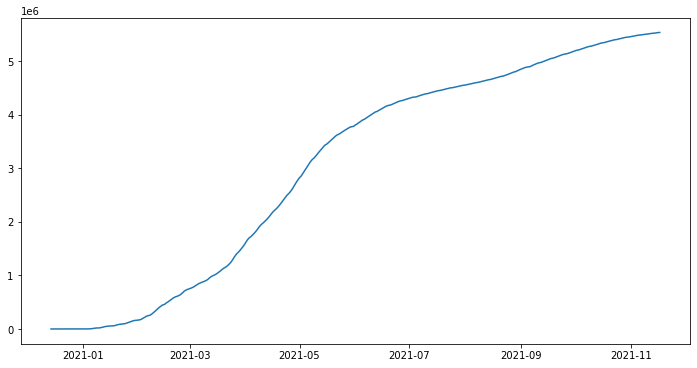

In [17]:
fig = plt.figure(figsize=(12,6))
plt.plot(df_doses_by_day.DATE, df_doses_by_day.ADMIN_DOSE2_CUMULATIVE)
plt.show()

In [18]:
df_doses_by_day['full_vac_rate'] = df_doses_by_day.ADMIN_DOSE2_CUMULATIVE.div(POPULATION)

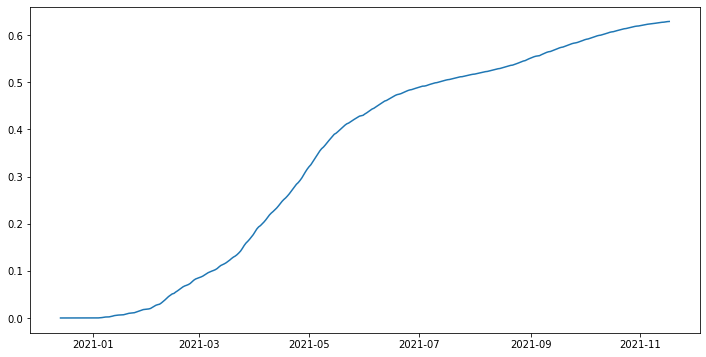

In [19]:
fig = plt.figure(figsize=(12,6))
plt.plot(df_doses_by_day.DATE, df_doses_by_day.full_vac_rate)
plt.show()

In [10]:
val = df_doses_by_day.full_vac_rate.values

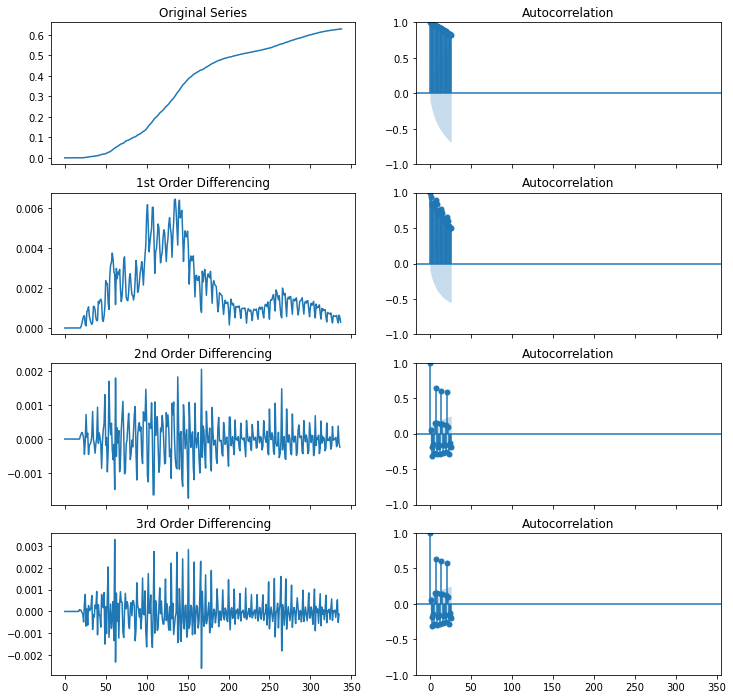

In [11]:
# Original Series
fig, axes = plt.subplots(4, 2, sharex=True, figsize=(12,12))
axes[0, 0].plot(val); axes[0, 0].set_title('Original Series')
plot_acf(val, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(np.diff(val)); axes[1, 0].set_title('1st Order Differencing')
plot_acf(np.diff(val), ax=axes[1, 1])
diffval = np.diff(val)

# 2nd Differencing
axes[2, 0].plot(np.diff(diffval)); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(np.diff(diffval), ax=axes[2, 1])
diffdiffval = np.diff(diffval)

axes[3, 0].plot(np.diff(diffdiffval)); axes[3, 0].set_title('3rd Order Differencing')
plot_acf(np.diff(diffval), ax=axes[3, 1])
plt.show()

### Second order differencing is good enough cause thrid order different gives no improvement

In [12]:
model = pm.auto_arima(val, start_p=7, start_q=7,
test='adf', # use adftest to find optimal 'd'
max_p=7, max_q=7, # maximum p and q
m=1, # frequency of series
d=None, # let model determine 'd'
seasonal=False, # No Seasonality
start_P=0,
D=0,
trace=True,
error_action='ignore',
suppress_warnings=True,
stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(7,2,7)(0,0,0)[0] intercept   : AIC=-4327.164, Time=1.55 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-4098.025, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-4096.930, Time=0.13 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-4096.523, Time=0.17 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-4100.019, Time=0.02 sec
 ARIMA(6,2,7)(0,0,0)[0] intercept   : AIC=-4330.012, Time=1.99 sec
 ARIMA(5,2,7)(0,0,0)[0] intercept   : AIC=-4341.744, Time=1.99 sec
 ARIMA(4,2,7)(0,0,0)[0] intercept   : AIC=-4315.473, Time=1.45 sec
 ARIMA(5,2,6)(0,0,0)[0] intercept   : AIC=-4324.439, Time=1.16 sec
 ARIMA(4,2,6)(0,0,0)[0] intercept   : AIC=-4293.983, Time=0.77 sec
 ARIMA(6,2,6)(0,0,0)[0] intercept   : AIC=-4326.373, Time=1.79 sec
 ARIMA(5,2,7)(0,0,0)[0]             : AIC=-4344.543, Time=0.70 sec
 ARIMA(4,2,7)(0,0,0)[0]             : AIC=-4317.626, Time=0.95 sec
 ARIMA(5,2,6)(0,0,0)[0]             : AIC=-4328.250, Time=0.80 sec
 ARIMA(6,2,7)(0,0,0

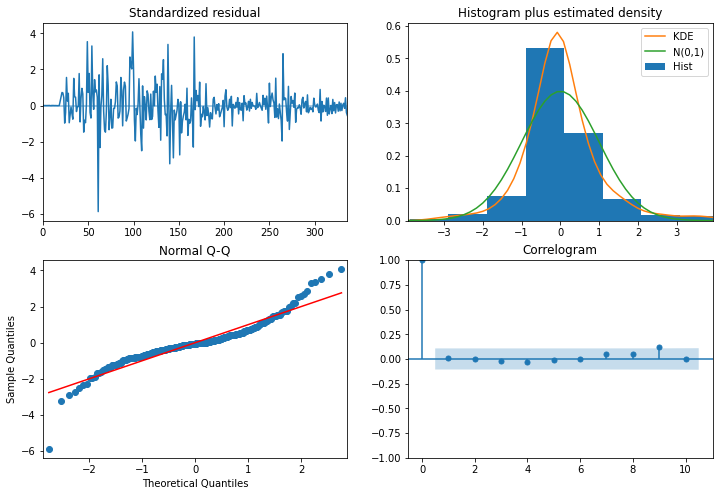

In [15]:
model.plot_diagnostics(figsize=(12,8))
plt.show()

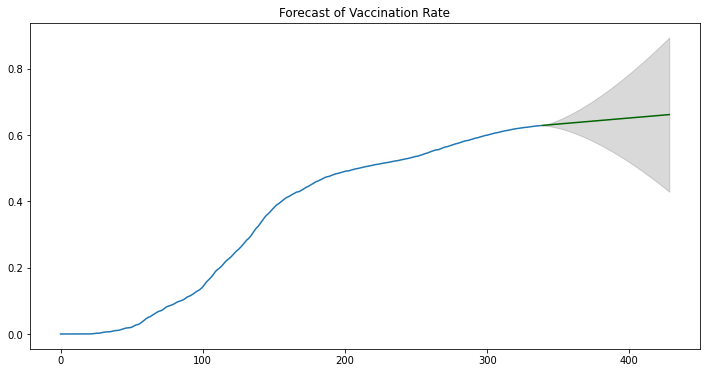

In [18]:
# Forecast
n_periods = 90
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(val), len(val)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
fig = plt.figure(figsize=(12,6))
plt.plot(val)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index,
lower_series,
upper_series,
color='k', alpha=.15)
plt.title("Forecast of Vaccination Rate")
plt.show()

### Repeat the same process for infection data

In [2]:
df_cases_by_day = pd.read_csv("./coronavirus-data/trends/cases-by-day.csv")
df_cases_by_day['date_of_interest'] = pd.to_datetime(df_cases_by_day['date_of_interest'])
df_cases_by_day.columns

Index(['date_of_interest', 'CASE_COUNT', 'PROBABLE_CASE_COUNT',
       'CASE_COUNT_7DAY_AVG', 'ALL_CASE_COUNT_7DAY_AVG', 'BX_CASE_COUNT',
       'BX_PROBABLE_CASE_COUNT', 'BX_CASE_COUNT_7DAY_AVG',
       'BX_ALL_CASE_COUNT_7DAY_AVG', 'BK_CASE_COUNT', 'BK_PROBABLE_CASE_COUNT',
       'BK_CASE_COUNT_7DAY_AVG', 'BK_ALL_CASE_COUNT_7DAY_AVG', 'MN_CASE_COUNT',
       'MN_PROBABLE_CASE_COUNT', 'MN_CASE_COUNT_7DAY_AVG',
       'MN_ALL_CASE_COUNT_7DAY_AVG', 'QN_CASE_COUNT', 'QN_PROBABLE_CASE_COUNT',
       'QN_CASE_COUNT_7DAY_AVG', 'QN_ALL_CASE_COUNT_7DAY_AVG', 'SI_CASE_COUNT',
       'SI_PROBABLE_CASE_COUNT', 'SI_CASE_COUNT_7DAY_AVG',
       'SI_ALL_CASE_COUNT_7DAY_AVG', 'INCOMPLETE'],
      dtype='object')

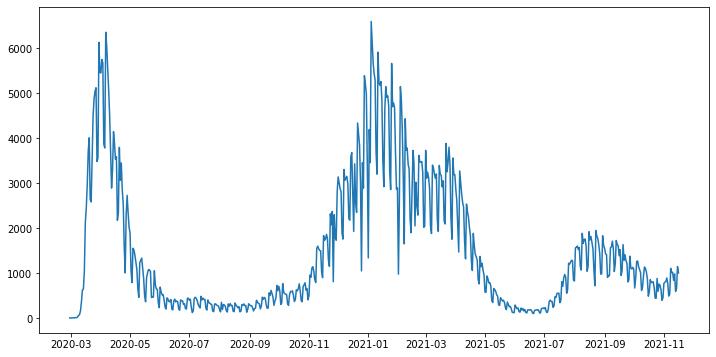

In [3]:
fig = plt.figure(figsize=(12,6))
plt.plot(df_cases_by_day.date_of_interest, df_cases_by_day.CASE_COUNT)
plt.show()

In [4]:
val = df_cases_by_day.CASE_COUNT

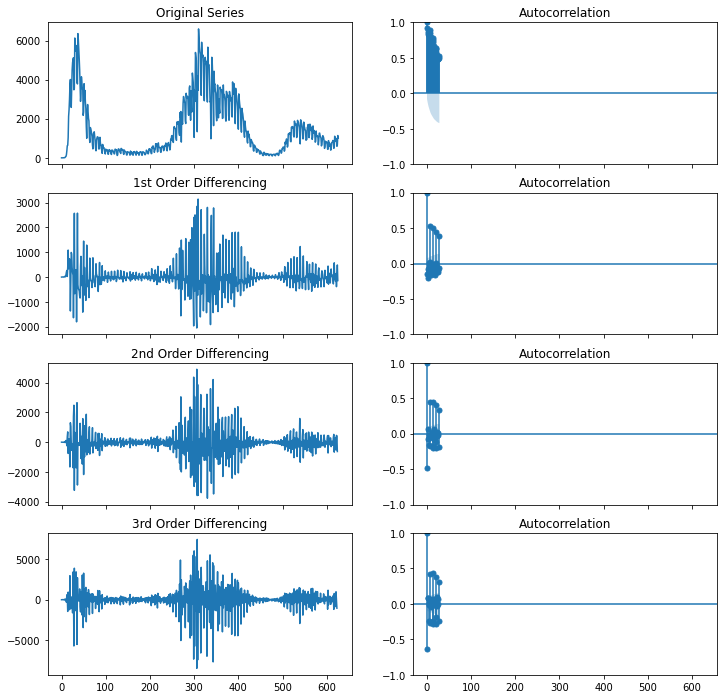

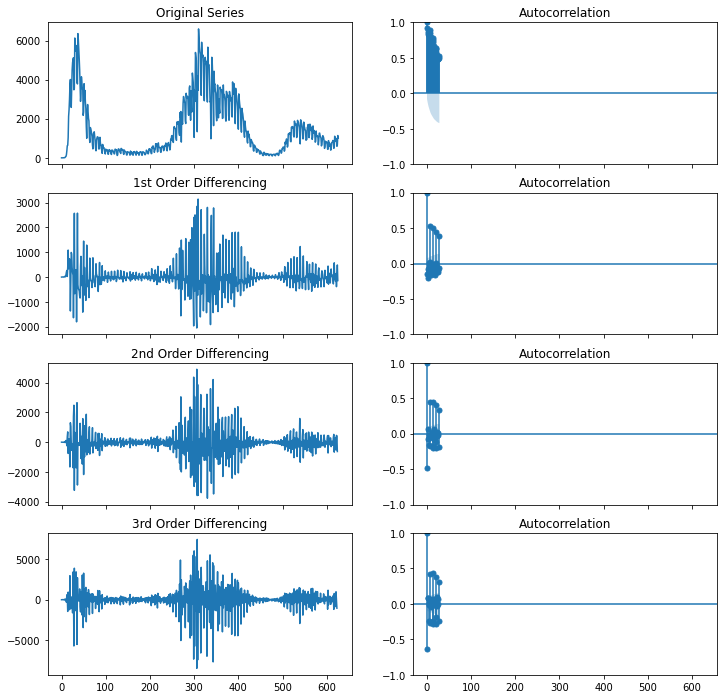

In [5]:
# Original Series
fig, axes = plt.subplots(4, 2, sharex=True, figsize=(12,12))
axes[0, 0].plot(val); axes[0, 0].set_title('Original Series')
plot_acf(val, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(np.diff(val)); axes[1, 0].set_title('1st Order Differencing')
plot_acf(np.diff(val), ax=axes[1, 1])
diffval = np.diff(val)

# 2nd Differencing
axes[2, 0].plot(np.diff(diffval)); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(np.diff(diffval), ax=axes[2, 1])
diffdiffval = np.diff(diffval)

axes[3, 0].plot(np.diff(diffdiffval)); axes[3, 0].set_title('3rd Order Differencing')
plot_acf(np.diff(diffdiffval), ax=axes[3, 1])

In [6]:
model = pm.auto_arima(val, start_p=7, start_q=7,
test='adf', # use adftest to find optimal 'd'
max_p=7, max_q=7, # maximum p and q
m=1, # frequency of series
d=None, # let model determine 'd'
seasonal=False, # No Seasonality
start_P=0,
D=0,
trace=True,
error_action='ignore',
suppress_warnings=True,
stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(7,1,7)(0,0,0)[0] intercept   : AIC=9388.809, Time=3.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9760.938, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9748.168, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9727.571, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9758.943, Time=0.01 sec
 ARIMA(6,1,7)(0,0,0)[0] intercept   : AIC=9376.751, Time=2.94 sec
 ARIMA(5,1,7)(0,0,0)[0] intercept   : AIC=9405.388, Time=3.16 sec
 ARIMA(6,1,6)(0,0,0)[0] intercept   : AIC=9392.673, Time=2.53 sec
 ARIMA(5,1,6)(0,0,0)[0] intercept   : AIC=9425.987, Time=2.50 sec
 ARIMA(7,1,6)(0,0,0)[0] intercept   : AIC=9385.526, Time=2.86 sec
 ARIMA(6,1,7)(0,0,0)[0]             : AIC=9374.310, Time=2.81 sec
 ARIMA(5,1,7)(0,0,0)[0]             : AIC=9403.412, Time=2.52 sec
 ARIMA(6,1,6)(0,0,0)[0]             : AIC=9390.666, Time=1.98 sec
 ARIMA(7,1,7)(0,0,0)[0]             : AIC=9382.600, Time=2.52 sec
 ARIMA(5,1,6)(0,0,0)[0]          

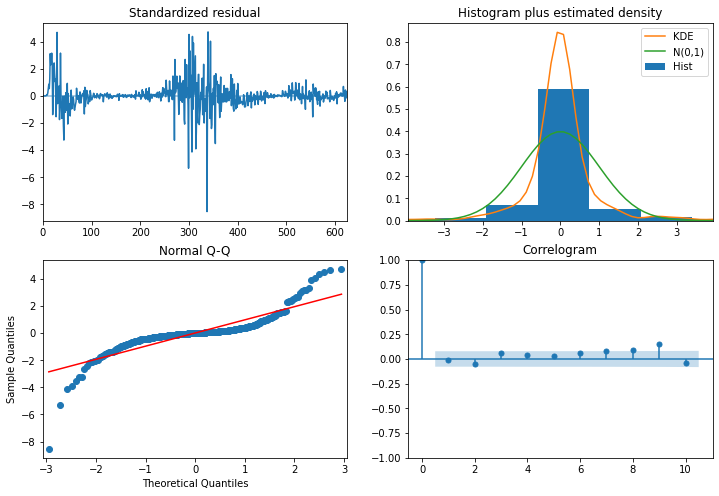

In [7]:
model.plot_diagnostics(figsize=(12,8))
plt.show()

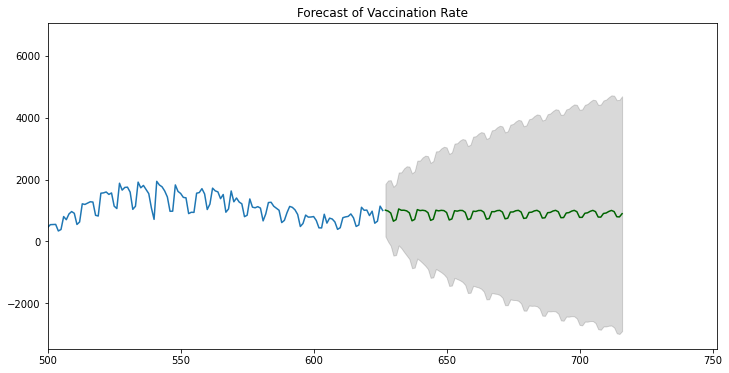

In [9]:
# Forecast
n_periods = 90
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(val), len(val)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
fig = plt.figure(figsize=(12,6))
plt.plot(val)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index,
lower_series,
upper_series,
color='k', alpha=.15)
plt.title("Forecast of Vaccination Rate")
plt.xlim(500)
plt.show()

In [20]:
df_doses_by_day.columns

Index(['DATE', 'ADMIN_DOSE1_DAILY', 'ADMIN_DOSE1_CUMULATIVE',
       'ADMIN_DOSE2_DAILY', 'ADMIN_DOSE2_CUMULATIVE', 'ADMIN_SINGLE_DAILY',
       'ADMIN_SINGLE_CUMULATIVE', 'ADMIN_ALLDOSES_DAILY',
       'ADMIN_ALLDOSES_7DAYAVG', 'ADMIN_ALLDOSES_CUMULATIVE', 'INCOMPLETE',
       'full_vac_rate'],
      dtype='object')

In [22]:
df_cases_by_day.columns

Index(['date_of_interest', 'CASE_COUNT', 'PROBABLE_CASE_COUNT',
       'CASE_COUNT_7DAY_AVG', 'ALL_CASE_COUNT_7DAY_AVG', 'BX_CASE_COUNT',
       'BX_PROBABLE_CASE_COUNT', 'BX_CASE_COUNT_7DAY_AVG',
       'BX_ALL_CASE_COUNT_7DAY_AVG', 'BK_CASE_COUNT', 'BK_PROBABLE_CASE_COUNT',
       'BK_CASE_COUNT_7DAY_AVG', 'BK_ALL_CASE_COUNT_7DAY_AVG', 'MN_CASE_COUNT',
       'MN_PROBABLE_CASE_COUNT', 'MN_CASE_COUNT_7DAY_AVG',
       'MN_ALL_CASE_COUNT_7DAY_AVG', 'QN_CASE_COUNT', 'QN_PROBABLE_CASE_COUNT',
       'QN_CASE_COUNT_7DAY_AVG', 'QN_ALL_CASE_COUNT_7DAY_AVG', 'SI_CASE_COUNT',
       'SI_PROBABLE_CASE_COUNT', 'SI_CASE_COUNT_7DAY_AVG',
       'SI_ALL_CASE_COUNT_7DAY_AVG', 'INCOMPLETE'],
      dtype='object')

In [27]:
df_new_infec = df_cases_by_day[['date_of_interest','CASE_COUNT']]
df_new_infec.rename(columns={'date_of_interest':'date', 'CASE_COUNT':'case'},inplace=True)
df_new_infec.head()

C:\Python39\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,date,case
0,2020-02-29,1
1,2020-03-01,0
2,2020-03-02,0
3,2020-03-03,1
4,2020-03-04,5


In [28]:
df_full_vac = df_doses_by_day[['DATE', 'full_vac_rate']]
df_full_vac.rename(columns={'DATE':'date'},inplace=True)
df_full_vac.head()

C:\Python39\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,date,full_vac_rate
0,2020-12-14,0.000000e+00
1,2020-12-15,3.407468e-07
2,2020-12-16,1.930899e-06
3,2020-12-17,3.861798e-06
4,2020-12-18,6.587772e-06


In [30]:
vac_i = df_full_vac.date.min()
vac_f = df_full_vac.date.max()
print(vac_i, vac_f)

2020-12-14 00:00:00 2021-11-17 00:00:00


In [31]:
inf_i = df_new_infec.date.min()
inf_f = df_new_infec.date.max()
print(inf_i, inf_f)

2020-02-29 00:00:00 2021-11-16 00:00:00


In [33]:
date_i = max(vac_i, inf_i)
date_f = min(vac_f, inf_f)
print(date_i, date_f)

2020-12-14 00:00:00 2021-11-16 00:00:00


In [35]:
df_full_vac = df_full_vac[(df_full_vac.date>=date_i)&(df_full_vac.date<=date_f)]
df_new_infec = df_new_infec[(df_new_infec.date>=date_i)&(df_new_infec.date<=date_f)]

In [37]:
df_full_vac

,date,full_vac_rate
0,2020-12-14,0.000000e+00
1,2020-12-15,3.407468e-07
2,2020-12-16,1.930899e-06
3,2020-12-17,3.861798e-06
4,2020-12-18,6.587772e-06
...,...,...
333,2021-11-12,6.266900e-01
334,2021-11-13,6.270916e-01
335,2021-11-14,6.273475e-01
336,2021-11-15,6.279933e-01


In [40]:
df_case_n_vac = pd.merge(df_new_infec, df_full_vac, on='date')

In [42]:
df_case_n_vac.to_csv("./df_case_n_vac.csv",index=False)